In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from itertools import combinations_with_replacement

In [3]:
class Economy:
    
    def __init__(self,vals,costs,num_ps,num_ks):
        self.num_cost = len(costs)
        self.val_dist = vals
        self.cost_dist = costs
        self.ks = np.linspace(0,1,num_ks).tolist()
        self.ps = np.linspace(0,1,num_ps).tolist()
        self.opt_p = None
        self.opt_con = None
        
    def Buyer_Problem(self, k):
        prices = [None for x in self.val_dist]
        for i, v in enumerate(self.val_dist):
            utilities = [(v-p)*sum([c<=p-k[x] for c in self.cost_dist])/self.num_cost for x,p in enumerate(self.ps)]
            # force buyers to post highest price when indifferent -> Equilibrium is when this happens
            m = max(utilities)
            l = [i for i, j in enumerate(utilities) if j == m]
            prices[i] = max([self.ps[x] for x in l])
        return prices
    
    def U_Problem(self):
        # this is the main time sink, I generate all contracts possible...
        contracts = list(product(self.ks,repeat=len(self.ks)))
        price_response = [self.Buyer_Problem(con) for con in contracts]
        utilities = [None for x in contracts]
        for i, con in enumerate(contracts):
            # price_response[i] is the list of prices for each v
            # i.e. price_response[i][v] is the optimal downstream
            # offer for contract number i for buyer valuation v
            util = 0
            for v in range(len(self.val_dist)):
                for c in self.cost_dist:
                    if (c<=price_response[i][v]-con[self.ps.index(price_response[i][v])]):
                        # ignore probability weightings as same for all so max not affected
                        util += (price_response[i][v]-c)
            utilities[i] = util
        self.opt_con = contracts[-np.argmax(utilities[::-1])]
        self.opt_p = price_response[np.argmax(utilities)]
        return (contracts[-np.argmax(utilities[::-1])],price_response[np.argmax(utilities)])
    
    def Graph(self):
        fig, axs = plt.subplots(2,dpi=100)
        axs[0].stem(self.val_dist,self.opt_p)
        axs[1].plot(self.opt_con)
        axs[0].set_title("Optimal Price, p(v)")     
        axs[1].set_title("Optimal Contract, k(p)")
        axs[0].set(xlabel ="Valuation")
        axs[1].set(xlabel = "Price")
        axs[0].set_xticks(self.val_dist)
        axs[0].set_yticks([round(x,2) for x in self.opt_p])
        xi = list(range(len(self.ps)))
        plt.xticks(xi, [round(x,2) for x in self.ps])
        axs[0].set_xticklabels([round(x,2) for x in self.val_dist], rotation=45)
        plt.xticks(rotation=-45)
        fig.tight_layout()
        plt.show()
        
                
        
    

# Known Valuation

First, check we can replicate the full surplus extraction contract when valuation is known.

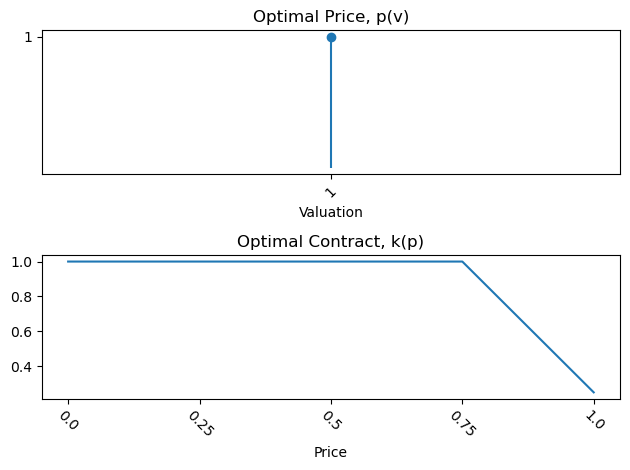

In [4]:
Econ_0 = Economy(vals=[1],
               costs=np.linspace(0,1,50).tolist(),
               num_ps=5,
               num_ks=5)
Econ_0.U_Problem()
Econ_0.Graph()

# Two Valuations, Two Costs

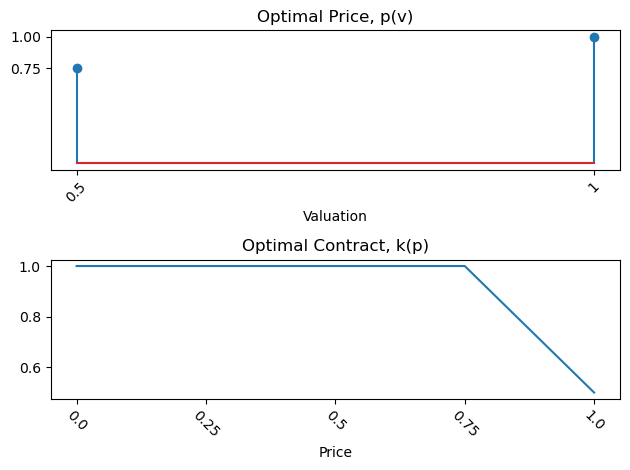

In [5]:
Econ_1 = Economy(vals=[0.5,1],
               costs=[0.25,0.75],
               num_ps=5,
               num_ks=5)
Econ_1.U_Problem()
Econ_1.Graph()

In [6]:
Econ_1.opt_p

[0.75, 1.0]

Valuation types are 0.5 or 1. We see see that the 0.5 valuation type is prevented from trading by the high contract price at k(0.75).

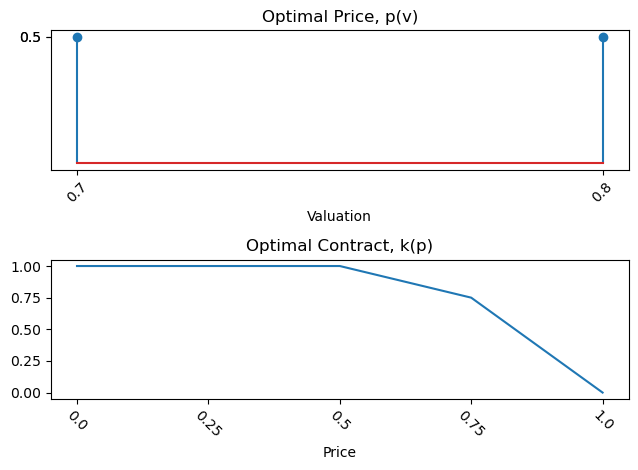

In [7]:
Econ_2 = Economy(vals=[0.7,0.8],
               costs=[0.25,0.75],
               num_ps=5,
               num_ks=5)
Econ_2.U_Problem()
Econ_2.Graph()

In [8]:
Econ_2.opt_p

[0.5, 0.5]

So we see that both buyers post the same price of 0.5 and the high cost type never trades.

# Many Valuations, Many Costs

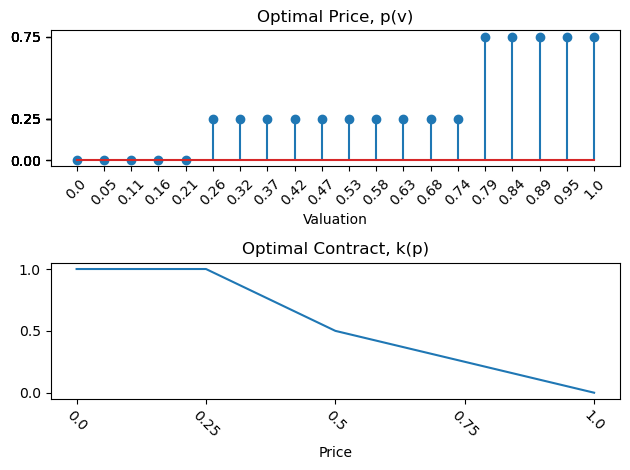

In [10]:
Econ_3 = Economy(vals=np.linspace(0,1,20).tolist(),
               costs=np.linspace(0,1,20).tolist(),
               num_ps=5,
               num_ks=5)
Econ_3.U_Problem()
Econ_3.Graph()

Looks like we can limit attention to decreasing contracts... 

In [13]:
# now restricting to only decreasing contract to ease memory constraint...
# think maybe if we do it interatively we can do more since right now it is storing all contracts
# into one list, might be better to do some sort of bubble sort
class Economy_Decreasing:
    
    def __init__(self,vals,costs,num_ps,num_ks):
        self.num_cost = len(costs)
        self.val_dist = vals
        self.cost_dist = costs
        self.ks = np.linspace(0,1,num_ks).tolist()
        self.ps = np.linspace(0,1,num_ps).tolist()
        self.opt_p = None
        self.opt_con = None
        
    def Buyer_Problem(self, k):
        prices = [None for x in self.val_dist]
        for i, v in enumerate(self.val_dist):
            utilities = [(v-p)*sum([c<=p-k[x] for c in self.cost_dist])/self.num_cost for x,p in enumerate(self.ps)]
            # force buyers to post highest price when indifferent -> Equilibrium is when this happens
            m = max(utilities)
            l = [i for i, j in enumerate(utilities) if j == m]
            prices[i] = max([self.ps[x] for x in l])
        return prices
    
    def U_Problem(self):
        # now only consider decreasing contracts
        contracts = list(combinations_with_replacement(self.ks[::-1],len(self.ks)))
        price_response = [self.Buyer_Problem(con) for con in contracts]
        utilities = [None for x in contracts]
        for i, con in enumerate(contracts):
            # price_response[i] is the list of prices for each v
            # i.e. price_response[i][v] is the optimal downstream
            # offer for contract number i for buyer valuation v
            util = 0
            for v in range(len(self.val_dist)):
                for c in self.cost_dist:
                    if (c<=price_response[i][v]-con[self.ps.index(price_response[i][v])]):
                        # ignore probability weightings as same for all so max not affected
                        util += (price_response[i][v]-c)
            utilities[i] = util
        self.opt_con = contracts[-np.argmax(utilities[::-1])]
        self.opt_p = price_response[np.argmax(utilities)]
        return (contracts[-np.argmax(utilities[::-1])],price_response[np.argmax(utilities)])
    
    def Graph(self):
        fig, axs = plt.subplots(2,dpi=100)
        axs[0].stem(self.val_dist,self.opt_p)
        axs[1].plot(self.opt_con)
        axs[0].set_title("Optimal Price, p(v)")     
        axs[1].set_title("Optimal Contract, k(p)")
        axs[0].set(xlabel ="Valuation")
        axs[1].set(xlabel = "Price")
        axs[0].set_xticks(self.val_dist)
        axs[0].set_yticks([round(x,2) for x in self.opt_p])
        xi = list(range(len(self.ps)))
        plt.xticks(xi, [round(x,2) for x in self.ps])
        axs[0].set_xticklabels([round(x,2) for x in self.val_dist], rotation=45)
        plt.xticks(rotation=-45)
        fig.tight_layout()
        plt.show()

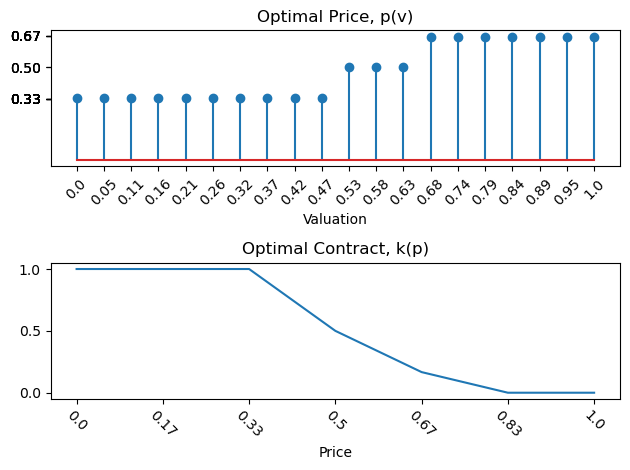

In [12]:
Econ_dec = Economy(vals=np.linspace(0,1,20).tolist(),
               costs=np.linspace(0,1,20).tolist(),
               num_ps=7,
               num_ks=7)
Econ_dec.U_Problem()
Econ_dec.Graph()